**Table of contents**<a id='toc0_'></a>    
- [Dataset & Libraries](#toc1_)    
- [Data Cleaning](#toc2_)    
- [Modeling](#toc3_)    
    - [Grid Search](#toc3_1_1_)    
  - [FunkSVD Model](#toc3_2_)    
  - [Predictions & Accuracy](#toc3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

I will now develop a model to predict the rating for each recipe based on the historical ratings given. Logic here is that, recipes with similar ratings could get similar rating by a user who has rated one of the two. 

# <a id='toc1_'></a>[Dataset & Libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np

In [2]:
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise import accuracy
from surprise.model_selection import train_test_split

In [3]:
ratings= pd.read_csv('/Users/anupajayakody/BrainStation/CAPSTONE/CAPSTONE_GITHUB/Capstone/Notebooks/reviews.csv')
ratings.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [4]:
ratings.shape

(1401982, 8)

# <a id='toc2_'></a>[Data Cleaning](#toc0_)

In [5]:
ratings.isna().sum()/ratings.shape[0]*100

ReviewId         0.000000
RecipeId         0.000000
AuthorId         0.000000
AuthorName       0.000000
Rating           0.000000
Review           0.015264
DateSubmitted    0.000000
DateModified     0.000000
dtype: float64

Given that there are no null values in  the rating column, we will not drop any data here. 

In [6]:
ratings.duplicated().sum()

0

No duplicate values as well

In [7]:
ratings_ = ratings.sort_values(by=['AuthorId', 'RecipeId'])
ratings_.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
145848,156476,2137,1533,Dancer,5,OUTSTANDING was the only comments my guests ma...,2005-02-27T09:30:26Z,2005-02-27T09:30:26Z
62702,69050,2585,1533,Dancer,1,Sorry this wasn't what I expected. I love chic...,2003-09-26T19:27:03Z,2003-09-26T19:27:03Z
154718,165873,4213,1533,Dancer,5,"This is the best I have tasted, I have made it...",2005-04-10T09:43:57Z,2005-04-10T09:43:57Z
18652,22342,8857,1533,Dancer,5,"I'm Dancing around my kitchen, finally I have ...",2002-08-23T17:58:39Z,2002-08-23T17:58:39Z
142105,152525,10332,1533,Dancer,5,Hi Bergy..Yesterday was a little rushed for me...,2005-02-09T08:03:54Z,2005-02-09T08:03:54Z


In [8]:
ratings.groupby('Rating')['RecipeId'].count()

Rating
0      76248
1      16559
2      17597
3      50279
4     229217
5    1012082
Name: RecipeId, dtype: int64

It is visible that 72% of the ratings are of 5 and 16% of 4 constituting to 88% of high ratings in the dataset. 

# <a id='toc3_'></a>[Modeling](#toc0_)

In [9]:
my_dataset = Dataset.load_from_df(ratings_[['AuthorId', 'RecipeId', 'Rating']], Reader(rating_scale=(1, 5)))
#my_train_dataset = my_dataset.build_full_trainset()

### <a id='toc3_1_1_'></a>[Grid Search](#toc0_)

In [10]:
from surprise.model_selection import GridSearchCV

param_grid= {
    'n_factors' : [5,10,20,25],
    'n_epochs' : [5,10],
    'lr_all' : [0.1, 0.05, 0.005],
    'biased': [False]
}

grid_search= GridSearchCV(FunkSVD, param_grid, measures= ['fcp'], cv=3)
grid_search.fit(my_dataset)


Now checking the best parameters

In [11]:
grid_search.best_score['fcp']

0.641461702518939

In [12]:
grid_search.best_params['fcp']

{'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.005, 'biased': False}

## <a id='toc3_2_'></a>[FunkSVD Model](#toc0_)

In [13]:
# package doesn't allow you to test on the trainset we built
train_dataset, test_dataset = train_test_split(my_dataset, test_size=0.3)


funkSVD_model = FunkSVD(n_factors=10,
                       n_epochs=5,
                       lr_all=0.005,    # learning rate for each epoch
                       biased=False,  # frces the algorithm to store all latent information in the matrices
                       verbose=0)

funkSVD_model.fit(train_dataset) #fit on train set


predictions = funkSVD_model.test(test_dataset) #predictions on test set

## <a id='toc3_3_'></a>[Predictions & Accuracy](#toc0_)

In [14]:
#checcking test accuracy
FCP = accuracy.fcp(predictions, verbose=False)
print(FCP)

0.6430853190380813


In [15]:
#%%time ## prints time for the entire cell
train_dataset, test_dataset = train_test_split(my_dataset, test_size=0.3)

fcps = []
factors = range(10, 201, 5)
for n_factors in factors:
    funkSVD_model_graph = FunkSVD(n_factors=n_factors,
                           n_epochs=5,
                           lr_all=0.005,    # Learning rate for each epoch
                           biased=False,  # This forces the algorithm to store all latent information in the matrices
                           verbose=0)

    funkSVD_model_graph.fit(train_dataset)
    predictions_graph = funkSVD_model_graph.test(test_dataset)

    FCP_graph = accuracy.fcp(predictions_graph, verbose=False)
    fcps.append(FCP_graph)
    

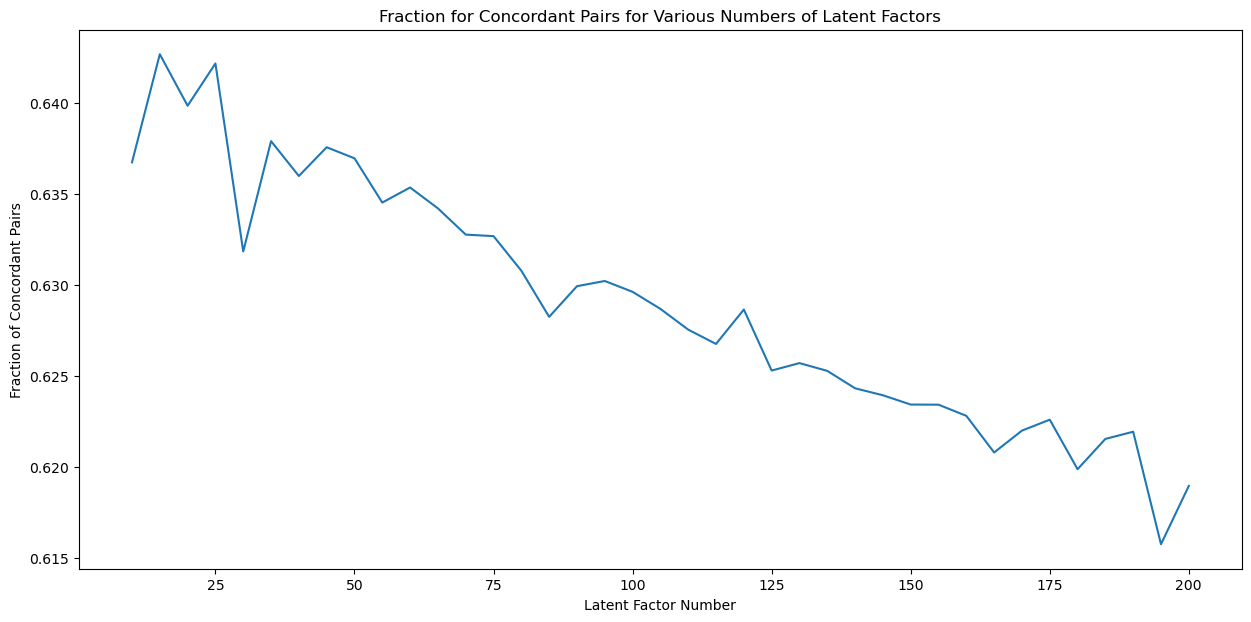

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(factors, fcps)
plt.xlabel("Latent Factor Number")
plt.ylabel("Fraction of Concordant Pairs")
plt.title("Fraction for Concordant Pairs for Various Numbers of Latent Factors")
plt.show()

It can be seen that test accuracy has improved slightly. I will now load the predictions to a dataframe and check the difference between the predictions & actuals

In [17]:
predictions_df = pd.DataFrame(predictions, columns=['AuthorId',
                                                     'RecipeId',
                                                     'ActualRating',
                                                     'PredictedRating', 
                                                     'Details'])

predictions_df

,AuthorId,RecipeId,ActualRating,PredictedRating,Details
0,465829,231517,5.0,1.000000,{'was_impossible': False}
1,2001622054,176574,2.0,4.408318,"{'was_impossible': True, 'reason': 'User and i..."
2,56463,162379,5.0,5.000000,{'was_impossible': False}
3,559517,26820,5.0,1.814023,{'was_impossible': False}
4,3539,19107,4.0,1.000000,{'was_impossible': False}
...,...,...,...,...,...
420590,416758,28377,5.0,2.974410,{'was_impossible': False}
420591,164293,146330,5.0,1.000000,{'was_impossible': False}
420592,32058,151732,5.0,4.898040,{'was_impossible': False}
420593,788414,50979,5.0,3.618437,{'was_impossible': False}


In [18]:
predictions_df['RatingDiff']= abs(predictions_df['PredictedRating']- predictions_df['ActualRating']) #differences

In [19]:
predictions_df.sort_values(by='RatingDiff').head(20) #rating diff zero sample

,AuthorId,RecipeId,ActualRating,PredictedRating,Details,RatingDiff
217862,80998,17086,5.0,5.0,{'was_impossible': False},0.0
41639,2000211897,256890,1.0,1.0,{'was_impossible': False},0.0
122797,94087,39087,5.0,5.0,{'was_impossible': False},0.0
122795,445492,89204,5.0,5.0,{'was_impossible': False},0.0
351547,133174,26306,5.0,5.0,{'was_impossible': False},0.0
351542,197023,96003,5.0,5.0,{'was_impossible': False},0.0
351541,199848,22751,5.0,5.0,{'was_impossible': False},0.0
216389,446143,245944,5.0,5.0,{'was_impossible': False},0.0
216394,229850,35450,5.0,5.0,{'was_impossible': False},0.0
216408,80353,66603,5.0,5.0,{'was_impossible': False},0.0


In [20]:
predictions_df.sort_values(by='RatingDiff').tail(20) #worst rating diff sample

,AuthorId,RecipeId,ActualRating,PredictedRating,Details,RatingDiff
41280,678366,71499,0.0,5.0,{'was_impossible': False},5.0
3104,593927,347583,0.0,5.0,{'was_impossible': False},5.0
214471,309368,45809,0.0,5.0,{'was_impossible': False},5.0
227898,439797,70018,0.0,5.0,{'was_impossible': False},5.0
275677,250031,79606,0.0,5.0,{'was_impossible': False},5.0
283774,164368,69630,0.0,5.0,{'was_impossible': False},5.0
298925,84272,87782,0.0,5.0,{'was_impossible': False},5.0
291763,58104,60598,0.0,5.0,{'was_impossible': False},5.0
403481,369715,26947,0.0,5.0,{'was_impossible': False},5.0
396617,30534,157964,0.0,5.0,{'was_impossible': False},5.0
